In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle

In [5]:
# import data
data = pd.read_csv('../../data/definitive_dataset.csv')
data['date'] = pd.to_datetime(data['date'])

# load selected features with pickle
with open('../../data/selected_features.pkl', 'rb') as f:
    selected_features = pickle.load(f)

price_data = pd.read_csv('../../data/non_diff_adjusted_price_data.csv')
price_data['date'] = pd.to_datetime(price_data['date'])

Period: 2008-01-01 00:00:00

Training features:
['stat_divyeld', '12_month_return', '3_month_return', 'fed_funds_volume', 'CAPEI', 'de_ratio', 'debt_ebitda', 'pe_op_dil', 'pe_exi', 'staff_sale', 'ptpm', 'GProf', 'roe', 'debt_invcap', 'aftret_equity', 'cash_lt', 'debt_at', 'short_debt', 'fcf_ocf', 'lt_ppent', 'ptb', 'rect_turn', 'pay_turn', 'adv_sale', 'mktcap', 'ret_industry_tot', 'MACD_index', 'vol', 'ret', 'prc_adj', 'rsi', 'ret_industry_relative', 'fed_funds_adj_close']
First trading date: 2010-01-04 00:00:00
Return date: 2010-04-01 00:00:00


,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%),target
0,10104,0.944693,0.055307,0,False,7.387719,10104,8.017096,8.519228,1.0
1,10107,0.391212,0.608788,1,False,5.227479,10107,5.066826,-3.073245,0.0
2,10137,0.168679,0.831321,1,True,6.912729,10137,7.076487,2.368937,1.0
3,10138,0.548906,0.451094,0,False,19.628916,10138,20.278299,3.308297,1.0
4,10145,0.256779,0.743221,1,True,7.657640,10145,9.767455,27.551752,1.0
...,...,...,...,...,...,...,...,...,...,...
611,92618,0.318254,0.681746,1,True,4.033691,92618,5.131214,27.208895,1.0
612,92655,0.232954,0.767046,1,True,4.322705,92655,4.918431,13.781331,1.0
613,92709,0.308310,0.691690,1,True,12.536904,92709,13.989544,11.586908,1.0
614,92772,0.053084,0.946916,1,True,3.685129,92772,4.407173,19.593424,1.0


Top 15 long predictions:


,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%)
543,89509,0.000205,0.999795,1,True,23.264609,89509,26.846428,15.395998
589,91392,0.002920,0.997080,1,True,3.862682,91392,5.101083,32.060644
349,76605,0.004698,0.995302,1,True,23.989694,76605,27.151821,13.181191
602,92121,0.005247,0.994753,1,False,4.448738,92121,4.364759,-1.887705
361,77037,0.006076,0.993924,1,True,1.395639,77037,2.162179,54.923942
573,90720,0.006227,0.993773,1,False,0.642005,90720,0.597006,-7.009147
588,91391,0.008487,0.991513,1,False,20.362492,91391,20.312455,-0.245730
107,23660,0.008755,0.991245,1,True,3.889792,23660,4.280853,10.053515
280,62148,0.010053,0.989947,1,True,1.101378,62148,1.187562,7.825069
590,91416,0.011795,0.988205,1,True,2.150650,91416,2.570090,19.502926


----------------------------------------------------------
Top 15 short predictions:


,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%)
397,79588,0.997253,0.002747,0,False,10.981946,79588,12.577001,14.524340
494,86979,0.993651,0.006349,0,False,27.180000,86979,30.450000,12.030905
503,87432,0.992468,0.007532,0,False,7.153321,87432,7.687455,7.466940
487,86580,0.988955,0.011045,0,True,1.084840,86580,0.910157,-16.102192
228,51377,0.985300,0.014700,0,True,13.815214,51377,12.996722,-5.924574
273,61241,0.979584,0.020416,0,True,2.989433,61241,2.897434,-3.077444
476,85991,0.978011,0.021989,0,False,24.150242,85991,24.300243,0.621118
270,60871,0.977773,0.022227,0,True,9.795606,60871,8.716465,-11.016583
262,59408,0.977128,0.022872,0,False,8.061165,59408,9.669364,19.949962
51,15456,0.973670,0.026330,0,False,6.017410,15456,8.108918,34.757620


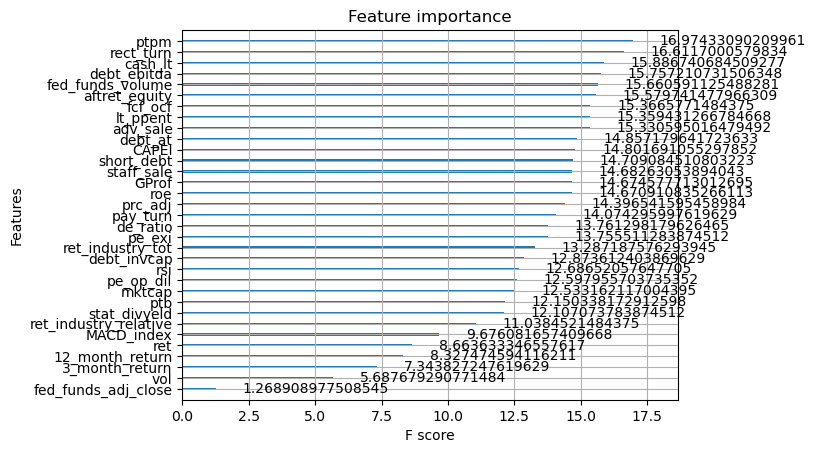


-----------------------------------------------------------------------------------------------------------------
Period: 2010-01-01 00:00:00

Training features:
['divyield', '12_month_return', '3_month_return', 'fed_funds_volume', 'CAPEI', 'staff_sale', 'debt_ebitda', 'pe_op_dil', 'pe_exi', 'ptpm', 'GProf', 'roe', 'aftret_invcapx', 'aftret_eq', 'debt_invcap', 'cash_lt', 'debt_at', 'fcf_ocf', 'dltt_be', 'de_ratio', 'rect_turn', 'pay_turn', 'ptb', 'adv_sale', 'prc', 'retx', 'naics_processed', 'MACD_index', 'vol', 'ret', 'prc_adj', 'rsi', 'ret_industry_relative', 'fed_funds_adj_close']
First trading date: 2012-01-03 00:00:00
Return date: 2012-04-02 00:00:00


,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%),target
0,10104,0.043131,0.956869,1,True,7.621537,10104,8.908066,16.880179,1.0
1,10107,0.470867,0.529133,1,True,4.806931,10107,6.049990,25.859725,1.0
2,10138,0.122442,0.877558,1,True,21.238408,10138,24.876229,17.128502,1.0
3,10145,0.166211,0.833789,1,True,11.098344,10145,12.889871,16.142290,1.0
4,10147,0.321793,0.678207,1,True,13.786449,10147,19.330676,40.215041,1.0
...,...,...,...,...,...,...,...,...,...,...
608,93132,0.614953,0.385047,0,False,1.208802,93132,1.534109,26.911528,1.0
609,93246,0.143698,0.856302,1,False,8.420395,93246,7.452750,-11.491679,0.0
610,93422,0.292281,0.707719,1,False,9.064762,93422,9.690903,6.907413,0.0
611,93429,0.602491,0.397509,0,False,5.573912,93429,5.924771,6.294665,1.0


Top 15 long predictions:


,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%)
421,82196,0.000591,0.999409,1,True,6.675082,82196,8.042115,20.479642
182,40125,0.001723,0.998277,1,True,4.413364,40125,5.622627,27.400027
539,89757,0.004524,0.995476,1,True,5.009358,89757,12.461521,148.764805
264,60442,0.008986,0.991014,1,True,25.614948,60442,29.011554,13.260248
35,12448,0.011109,0.988891,1,True,8.004132,12448,8.647908,8.043049
328,75573,0.011455,0.988545,1,True,6.448568,75573,9.300806,44.230570
338,76082,0.013886,0.986114,1,False,8.321461,76082,6.856833,-17.600618
282,63765,0.018070,0.981930,1,False,13.914893,63765,13.228852,-4.930265
604,92890,0.019937,0.980063,1,True,36.717883,92890,44.289699,20.621604
534,89509,0.020797,0.979203,1,True,27.331465,89509,32.980970,20.670332


----------------------------------------------------------
Top 15 short predictions:


,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%)
367,77481,0.997634,0.002366,0,False,8.451320,77481,8.983439,6.296277
33,12308,0.992261,0.007739,0,False,17.133241,12308,18.533508,8.172809
242,54148,0.974763,0.025237,0,False,2.053649,54148,2.466873,20.121439
74,18411,0.972506,0.027494,0,True,45.030000,18411,45.060000,0.066622
368,77496,0.970900,0.029100,0,False,26.685130,77496,29.628878,11.031417
493,87299,0.970350,0.029650,0,False,32.930000,87299,36.730000,11.539630
485,86964,0.964062,0.035938,0,False,105.940000,86964,136.660000,28.997546
240,53613,0.963934,0.036066,0,False,2.870296,53613,3.367666,17.328185
117,24010,0.960341,0.039659,0,True,46.843890,24010,43.205665,-7.766700
411,81138,0.957021,0.042979,0,True,24.215073,81138,16.350674,-32.477288


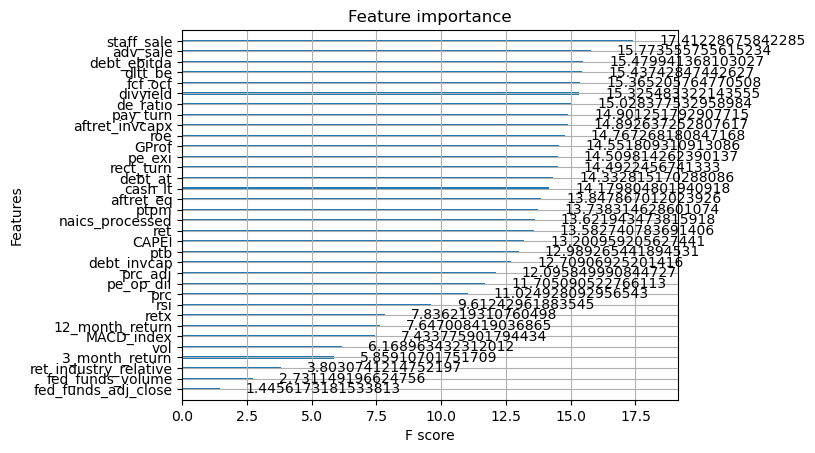


-----------------------------------------------------------------------------------------------------------------
Period: 2012-01-01 00:00:00

Training features:
['stat_divyeld', '12_month_return', 'fed_funds_volume', 'CAPEI', 'lt_ppent', 'evm', 'pe_inc', 'ps', 'pcf', 'ptpm', 'opmbd', 'roce', 'roe', 'aftret_eq', 'capital_ratio', 'GProf', 'cash_lt', 'debt_at', 'short_debt', 'fcf_ocf', 'sale_equity', 'rect_turn', 'pay_turn', 'adv_sale', 'staff_sale', 'mktcap', 'retx', 'MACD_index', 'vol', 'ret', 'prc_adj', 'rsi', 'ret_industry_relative', 'fed_funds_adj_close']
First trading date: 2014-01-02 00:00:00
Return date: 2014-04-02 00:00:00


,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%),target
0,10104,0.992751,0.007249,0,False,12.356250,10104,13.872460,12.270795,1.0
1,10107,0.486610,0.513390,1,True,7.097849,10107,8.336041,17.444613,1.0
2,10138,0.661702,0.338298,0,True,31.551721,10138,31.654330,0.325207,0.0
3,10145,0.830151,0.169849,0,False,19.411953,10145,20.128484,3.691186,1.0
4,10147,0.790644,0.209356,0,False,16.244032,10147,17.935922,10.415458,1.0
...,...,...,...,...,...,...,...,...,...,...
603,93132,0.902642,0.097358,0,False,1.057525,93132,1.289995,21.982407,1.0
604,93246,0.345879,0.654121,1,True,18.029809,93246,18.603222,3.180358,1.0
605,93422,0.504305,0.495695,0,True,9.495896,93422,9.902344,4.280247,0.0
606,93429,0.111104,0.888896,1,True,10.898378,93429,12.127919,11.281877,1.0


Top 15 long predictions:


,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%)
344,76185,0.001901,0.998099,1,False,21.647738,76185,19.940796,-7.885080
583,91926,0.003307,0.996693,1,True,12.273127,91926,16.765456,36.602974
477,86783,0.010946,0.989054,1,False,250.579223,86783,311.900101,24.471653
522,89195,0.011230,0.988770,1,False,26.601130,89195,25.588300,-3.807469
227,49015,0.011999,0.988001,1,False,39.536201,49015,39.019445,-1.307045
431,82775,0.012460,0.987540,1,False,19.482494,82775,19.463978,-0.095038
350,76614,0.014330,0.985670,1,True,58.154584,76614,69.014229,18.673755
384,79094,0.015647,0.984353,1,True,6.744154,79094,6.883386,2.064489
525,89258,0.016204,0.983796,1,False,59.466144,89258,55.445941,-6.760491
461,85675,0.016692,0.983308,1,True,20.448538,85675,21.920333,7.197558


----------------------------------------------------------
Top 15 short predictions:


,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%)
163,32707,0.998078,0.001922,0,False,54.253829,32707,69.912061,28.861063
500,88313,0.993815,0.006185,0,True,11.123519,88313,9.860791,-11.351873
0,10104,0.992751,0.007249,0,False,12.356250,10104,13.872460,12.270795
445,84342,0.992484,0.007516,0,False,5.482257,84342,5.855737,6.812521
560,90808,0.991526,0.008474,0,False,31.636576,90808,35.538178,12.332567
421,82298,0.983938,0.016062,0,True,25.657606,82298,21.342083,-16.819664
276,61241,0.983523,0.016477,0,False,1.244248,61241,1.318193,5.942942
107,22517,0.977812,0.022188,0,False,25.226129,22517,27.433427,8.750045
490,87432,0.977407,0.022593,0,False,12.764194,87432,13.001561,1.859633
83,18403,0.975855,0.024145,0,True,3.015182,18403,2.842781,-5.717763


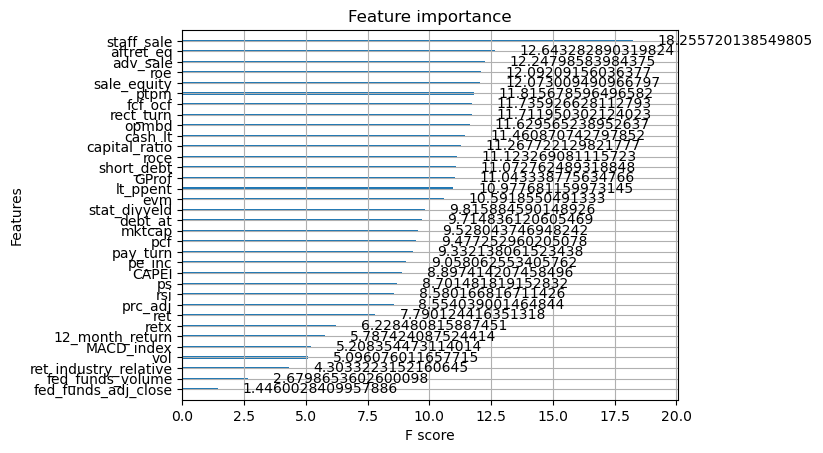


-----------------------------------------------------------------------------------------------------------------
Model xg_boost_2014-01-01_500_correct_dataset.pkl not found

-----------------------------------------------------------------------------------------------------------------
Model xg_boost_2016-01-01_500_correct_dataset.pkl not found

-----------------------------------------------------------------------------------------------------------------
Period: 2018-01-01 00:00:00

Training features:
['stat_divyeld', '12_month_return', 'fed_funds_volume', 'CAPEI', 'bm', 'debt_ebitda', 'pe_op_dil', 'pe_inc', 'ps', 'pcf', 'npm', 'opmbd', 'roce', 'aftret_eq', 'at_turn', 'debt_at', 'debt_invcap', 'cash_lt', 'short_debt', 'fcf_ocf', 'sale_equity', 'debt_capital', 'de_ratio', 'rect_turn', 'pay_turn', 'adv_sale', 'staff_sale', 'prc', 'retx', 'MACD_index', 'vol', 'ret', 'prc_adj', 'rsi', 'ret_industry_relative', 'fed_funds_adj_close']
First trading date: 2020-01-02 00:00:00
Return date:

,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%),target
0,10104,0.183466,0.816534,1,True,16.273579,10104,14.309087,-12.071661,1.0
1,10107,0.651784,0.348216,0,False,29.220462,10107,30.928455,5.845194,1.0
2,10138,0.169615,0.830385,1,False,45.037411,10138,36.144347,-19.745948,0.0
3,10145,0.883770,0.116230,0,True,38.825306,10145,32.021926,-17.523056,0.0
4,10516,0.527705,0.472295,0,True,17.392483,10516,13.589610,-21.865037,0.0
...,...,...,...,...,...,...,...,...,...,...
544,93132,0.594635,0.405365,0,False,5.559997,93132,5.810938,4.513329,1.0
545,93246,0.377259,0.622741,1,True,30.555190,93246,30.036612,-1.697185,1.0
546,93422,0.585723,0.414277,0,True,1.477220,93422,0.085605,-94.204970,0.0
547,93429,0.914153,0.085847,0,True,26.839001,93429,18.750905,-30.135610,0.0


Top 15 long predictions:


,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%)
92,16816,0.008065,0.991935,1,False,35.270087,16816,21.605749,-38.742002
484,89301,0.011905,0.988095,1,False,1.372019,89301,0.775430,-43.482583
436,85792,0.011982,0.988018,1,False,8.654747,85792,8.282513,-4.300918
518,91152,0.018452,0.981548,1,False,114.005184,91152,49.233209,-56.814938
63,14601,0.018671,0.981329,1,False,8.747542,14601,4.826013,-44.830068
254,52708,0.023365,0.976635,1,False,17.081595,52708,11.194845,-34.462533
70,14939,0.025627,0.974373,1,True,22.163658,14939,17.817257,-19.610484
241,49373,0.025987,0.974013,1,False,12.665559,49373,7.457337,-41.121137
114,18578,0.027293,0.972707,1,False,18.753635,18578,6.965884,-62.855817
486,89508,0.028474,0.971526,1,False,37.921686,89508,22.588127,-40.434802


----------------------------------------------------------
Top 15 short predictions:


,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%)
37,13141,0.999702,0.000298,0,True,7.522530,13141,1.677257,-77.703557
45,13641,0.999459,0.000541,0,True,51.124032,13641,15.483044,-69.714745
533,92239,0.998290,0.001710,0,True,48.281893,92239,23.606174,-51.107606
437,85913,0.995456,0.004544,0,True,39.702401,85913,18.029699,-54.587889
323,75034,0.994409,0.005591,0,True,19.646627,75034,7.860850,-59.988807
126,21207,0.992748,0.007252,0,False,39.108885,21207,40.574615,3.747818
228,45911,0.991306,0.008694,0,True,45.100226,45911,34.675129,-23.115398
453,87137,0.990272,0.009728,0,True,19.922966,87137,5.366030,-73.066106
449,86868,0.989473,0.010527,0,True,85.444412,86868,55.890104,-34.588930
239,49015,0.988523,0.011477,0,True,45.168487,49015,20.232046,-55.207608


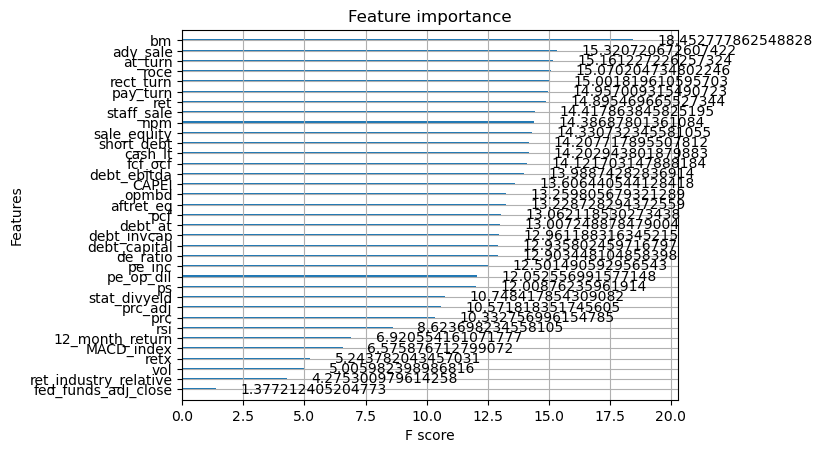


-----------------------------------------------------------------------------------------------------------------


In [13]:
for period in selected_features:
    start_date = pd.to_datetime(period)
    end_date = start_date + pd.DateOffset(years=2) - pd.DateOffset(days=91)

    training_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
    training_features = selected_features[start_date]

    X = training_data[training_features].copy()
    y = training_data['target'].copy()
    negative_mask = (y == -1)
    y[negative_mask] = 0

    # import the model with pickle
    n_estimators = 500
    start_date_str = start_date.strftime('%Y-%m-%d')
    model_name = f'xg_boost_{start_date_str}_{n_estimators}_correct_dataset.pkl'
    try:
        with open(f'../../models/final_models/{model_name}', 'rb') as f:
            model = pickle.load(f)
    except FileNotFoundError:
        print(f'Model {model_name} not found')
        print('')
        print('-----------------------------------------------------------------------------------------------------------------')    
        continue
    first_trading_date = start_date + pd.DateOffset(years=2)
    dates = data['date'].unique()

    # Print basic infomation:
    print(f'Period: {period}\n')
    print(f'Training features:\n{training_features}')

    # find the first trading day after the end date
    while first_trading_date not in dates:
        first_trading_date += pd.DateOffset(days=1)

    print(f'First trading date: {first_trading_date}')

    X_prediction_mask = data['date'] == first_trading_date
    X_prediction = data[X_prediction_mask][training_features].copy()

    assert len(X_prediction) > 0, 'No data to predict'
    permnos_first_trading_day = data[X_prediction_mask]['permno'].copy()
    target = data[X_prediction_mask]['target'].copy()
    target[target == -1] = 0


    return_date = first_trading_date + pd.DateOffset(days=90)

    # find the first trading day after the end date
    while return_date not in dates:
        return_date -= pd.DateOffset(days=1)

    print(f'Return date: {return_date}')

    X_return_mask = price_data['date'] == return_date
    X_prediction_mask = price_data['date'] == first_trading_date

    # calculate 90 days return
    trading_day_price = price_data[X_prediction_mask][['permno', 'prc_adj']].copy()
    return_day_price = price_data[X_return_mask]['prc_adj'].copy()
    permnos_return = price_data[X_return_mask]['permno'].copy()


    # find the predictions
    y_pred_proba = model.predict_proba(X_prediction)
    y_pred = model.predict(X_prediction)

    # check if prediction is correct
    correct_prediction = y_pred == target

    # put the predictions in a dataframe
    predictions_df = pd.DataFrame({
        'permno': permnos_first_trading_day,
        '0_probability': y_pred_proba[:, 0],
        '1_probability': y_pred_proba[:, 1],
        'prediction': y_pred,
        'correct_prediction': correct_prediction
    })
    trading_day_price.rename(columns={'prc_adj': 'trading_day_price'}, inplace=True)
    predictions_df = pd.merge(predictions_df, trading_day_price, left_on='permno', right_on='permno', how='inner')

    return_price_df = pd.DataFrame({
        'permnos': permnos_return,
        'price_return': return_day_price,
    })

    # merge the two dataframes
    merged_df = pd.merge(predictions_df, return_price_df, left_on='permno', right_on='permnos')

    # calculate the return
    merged_df['return(%)'] = (merged_df['price_return'] / merged_df['trading_day_price'] - 1)*100


    # Sanity check to see if everything lines up 
    merged_df_2 = pd.merge(merged_df, price_data[price_data['date'] == first_trading_date][['permno', 'target']], left_on='permno', right_on='permno')
    display(merged_df_2)



    n = 15
    # find the n argmin and argmax
    top_n = merged_df['1_probability'].nlargest(n)
    bottom_n = merged_df['1_probability'].nsmallest(n)

    #features_to_print = ['permno','0_probability', '1_probability', 'correct_prediction', 'return(%)']

    print(f'Top {n} long predictions:')
    display(merged_df.loc[top_n.index])#[features_to_print])
    print('-'*58)
    print(f'Top {n} short predictions:')
    display(merged_df.loc[bottom_n.index])#[features_to_print])


    # gain is usually the most realiable metric to evaluate the importance of the features
    xgb.plot_importance(model, importance_type='gain')
    plt.show()

    print('')
    print('-----------------------------------------------------------------------------------------------------------------')

In [121]:
# define a function to predict the future stock direction, for each model it makes predictions every 3 months for the next 2 years. 
# It should then return the top n stock it has the most confidence in both long and short direction for each period

def get_predictions(period, n_estimators=500, short=True, number_of_stocks=15):
    start_date = pd.to_datetime(period)
    end_date = start_date + pd.DateOffset(years=2) - pd.DateOffset(days=91)

    training_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
    training_features = selected_features[start_date]
    
    X = training_data[training_features].copy()
    y = training_data['target'].copy()
    negative_mask = (y == -1)
    y[negative_mask] = 0

    # import the model with pickle
    start_date_str = start_date.strftime('%Y-%m-%d')
    model_name = f'xg_boost_{start_date_str}_{n_estimators}_correct_dataset.pkl'
    try:
        with open(f'../../models/final_models/{model_name}', 'rb') as f:
            model = pickle.load(f)
    except FileNotFoundError:
        print(f'Model {model_name} not found')
        print('')
        if short:
            return None, None
        return None

    first_trading_date = start_date + pd.DateOffset(years=2)
    dates = data['date'].unique()
    # find the first trading day after the end date
    while first_trading_date not in dates:
        first_trading_date += pd.DateOffset(days=1)
    print(first_trading_date)
    dates = data['date'].unique()

    output_dict = {}
    if short:
        output_dict_short = {}
    for i in range(8):
        X_prediction_mask = (data['date'] == first_trading_date)
        X_prediction = data[X_prediction_mask][training_features].copy()

        assert len(X_prediction) > 0, 'No data to predict'
        permnos_first_trading_day = data[X_prediction_mask]['permno'].copy()
        target = data[X_prediction_mask]['target'].copy()
        target[target == -1] = 0

        return_date = first_trading_date + pd.DateOffset(days=90)

        # find the first trading day after the end date
        while return_date not in dates:
            if i % 2 == 1:
                return_date += pd.DateOffset(days=1)
            else:
                return_date -= pd.DateOffset(days=1)

        # find the predictions
        y_pred_proba = model.predict_proba(X_prediction)

        predictions_df = pd.DataFrame({
            'permno': permnos_first_trading_day,
            '0_probability': y_pred_proba[:, 0],
            '1_probability': y_pred_proba[:, 1],
        })

        # find the n argmin and argmax
        top_n = predictions_df['1_probability'].nlargest(number_of_stocks)
        # if any element in top_n has predictions_df['1_probability'] <0.5, then we remove it
        top_n = top_n[predictions_df.loc[top_n.index]['1_probability'] >= 0.5]
        if short:
            bottom_n = predictions_df['1_probability'].nsmallest(number_of_stocks)
            # if any element in bottom_n has predictions_df['1_probability'] >0.5, then we remove it
            bottom_n = bottom_n[predictions_df.loc[bottom_n.index]['1_probability'] <= 0.5]
            
        # put the predictions in output_dict
        output_dict[f'{start_date}_{i}'] = {
            'permno': predictions_df.loc[top_n.index]['permno'].values,
            'permno_probabilities': top_n.values
        }
        if short:
            output_dict_short[f'{start_date}_{i}'] = {
                'permno': predictions_df.loc[bottom_n.index]['permno'].values,
                'permno_probabilities': bottom_n.values
            }
        
        # move to next period:
        first_trading_date = return_date
    if short:
        return output_dict, output_dict_short
    else:
        return output_dict


In [123]:
# run get_prediction for all periods

all_predictions = {}
all_short_predictions = {}
for period in selected_features:
    predictions, short_predictions = get_predictions(period, n_estimators=500, short=True, number_of_stocks=10)
    if predictions is not None:
        all_predictions.update(predictions)
        all_short_predictions.update(short_predictions)

2010-01-04 00:00:00
2012-01-03 00:00:00
2014-01-02 00:00:00
Model xg_boost_2014-01-01_500_correct_dataset.pkl not found

Model xg_boost_2016-01-01_500_correct_dataset.pkl not found

2020-01-02 00:00:00


In [113]:
for i in all_predictions:
    print(i)
    print(all_predictions[i]['permno'])

2008-01-01 00:00:00_0
[89509]
2008-01-01 00:00:00_1
[78877]
2008-01-01 00:00:00_2
[90720]
2008-01-01 00:00:00_3
[66384]
2008-01-01 00:00:00_4
[91233]
2008-01-01 00:00:00_5
[87070]
2008-01-01 00:00:00_6
[87070]
2008-01-01 00:00:00_7
[87070]
2010-01-01 00:00:00_0
[82196]
2010-01-01 00:00:00_1
[91937]
2010-01-01 00:00:00_2
[57665]
2010-01-01 00:00:00_3
[80303]
2010-01-01 00:00:00_4
[89301]
2010-01-01 00:00:00_5
[91391]
2010-01-01 00:00:00_6
[90547]
2010-01-01 00:00:00_7
[90547]
2012-01-01 00:00:00_0
[76185]
2012-01-01 00:00:00_1
[86288]
2012-01-01 00:00:00_2
[66325]
2012-01-01 00:00:00_3
[90720]
2012-01-01 00:00:00_4
[27422]
2012-01-01 00:00:00_5
[90162]
2012-01-01 00:00:00_6
[92772]
2012-01-01 00:00:00_7
[11786]
2018-01-01 00:00:00_0
[16816]
2018-01-01 00:00:00_1
[36397]
2018-01-01 00:00:00_2
[36397]
2018-01-01 00:00:00_3
[36397]
2018-01-01 00:00:00_4
[49373]
2018-01-01 00:00:00_5
[90162]
2018-01-01 00:00:00_6
[90162]
2018-01-01 00:00:00_7
[90162]


In [120]:
for i in all_short_predictions:
    print(i)
    print(all_short_predictions[i]['permno'])
    print(all_short_predictions[i]['permno_probabilities'])

2008-01-01 00:00:00_0
[79588]
[0.00274739]
2008-01-01 00:00:00_1
[54181]
[0.00209514]
2008-01-01 00:00:00_2
[86964]
[0.01728031]
2008-01-01 00:00:00_3
[65875]
[0.00069632]
2008-01-01 00:00:00_4
[49656]
[0.00061968]
2008-01-01 00:00:00_5
[90199]
[0.00076272]
2008-01-01 00:00:00_6
[86783]
[0.00143962]
2008-01-01 00:00:00_7
[83111]
[2.3427709e-05]
2010-01-01 00:00:00_0
[77481]
[0.00236557]
2010-01-01 00:00:00_1
[90215]
[0.0014678]
2010-01-01 00:00:00_2
[90215]
[0.00036638]
2010-01-01 00:00:00_3
[76614]
[0.00055705]
2010-01-01 00:00:00_4
[90215]
[0.00135231]
2010-01-01 00:00:00_5
[18729]
[0.00070091]
2010-01-01 00:00:00_6
[58246]
[0.00113966]
2010-01-01 00:00:00_7
[79906]
[9.1062706e-05]
2012-01-01 00:00:00_0
[32707]
[0.00192199]
2012-01-01 00:00:00_1
[67467]
[0.00104772]
2012-01-01 00:00:00_2
[14295]
[0.00196575]
2012-01-01 00:00:00_3
[85035]
[0.00191758]
2012-01-01 00:00:00_4
[85035]
[0.00047514]
2012-01-01 00:00:00_5
[38156]
[0.00036869]
2012-01-01 00:00:00_6
[38156]
[0.00047293]
2012-0